In [1]:
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import random
from matplotlib import colors
import copy
import time
import scipy.optimize

%matplotlib inline

In [2]:
def plot_ising_grid(init, title):
    """Creates a discrete colormap for an input Ising grid, red for up (1) and blue for down (-1)"""
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    cmap = colors.ListedColormap(['blue', 'red'])
    bounds = [0,1,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(init, cmap=cmap, norm=norm)
    plt.title(title, fontsize=20)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    display.clear_output(wait = True)

    plt.show()

In [134]:
# assumes periodic BCs
def metropolis_ising_af(init, boltz):
    """Returns a mesh evolved by one step of applying the Metropolis algorithm, the energy change, 
    and the magnetization change"""
    
    mesh = copy.copy(init)
    
    X = np.shape(mesh)[1]
    Y = np.shape(mesh)[0]
    
    # select random spin from the input spin mesh
    x = random.choice(range(X))
    y = random.choice(range(Y))
    
    # applying the metropolis algorithm
    spin_sum = mesh[(y+1) % Y,x ] + mesh[y ,(x+1) % X] + mesh[(y-1) % Y,x ] + mesh[y ,(x-1) % X]
    d_energy = -2*mesh[y,x] * spin_sum
    
    if d_energy <= 0:
        mesh[y,x] = -1*mesh[y,x]
        d_mag = 2*mesh[y,x]
        
    elif random.uniform(0,1) < boltz[str(abs(spin_sum))]:
        mesh[y,x] = -1*mesh[y,x]
        d_mag = 2*mesh[y,x]
        
    else:
        d_energy = 0
        d_mag = 0
        
    if (x + y) % 2 == 1:
        d_mag = -1*d_mag
        

    return [mesh, d_energy, d_mag]

In [41]:
def mc_sweep_af(init, boltz):
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    for j in range(X):
        for i in range(Y):
            x = np.random.randint(X)
            y = np.random.randint(Y)
            spin = grid[y,x]
            
            spin_sum = grid[(y+1) % Y,x ] + grid[y,(x+1) % X] + grid[(y-1) % Y, x] + grid[y,(x-1) % X]
            d_energy = -2 * spin * spin_sum

            if d_energy <= 0:
                grid[y,x] = -1*grid[y,x]
                d_mag = 2*grid[y,x]

            elif random.uniform(0,1) < boltz[str(abs(spin_sum))]:
                grid[y,x] = -1*grid[y,x]
                d_mag = 2*grid[y,x]

            else:
                d_energy = 0
                d_mag = 0
        
    return grid
                
    

In [65]:
def mult_sweeps_af(init, boltz, N, plot = False, title = ''):
    """Similar to mc_sweep, but plotting per sweep"""
    
    grid = copy.copy(init)
    
    for n in range(N):
        grid = mc_sweep_af(grid, boltz)
    
    if plot == True:
        plot_ising_grid(grid, title)
        
    return grid

In [42]:
def ising_energy_af(init):
    """Computes the energy of a 2D square lattice in the Ising model"""
    
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    energy = 0
    
    for i in range(Y):
        for j in range(X):
            energy += init[i,j] * (init[(i+1) % Y ,j] + init[(i-1) % Y,j] + init[i,(j+1) % X] + init[i,(j-1) % X])
            
    energy = energy/2
    
    return energy

In [39]:
def energy_evo_af(init, boltz, n, plot = True):
    """Returns a list of energies for a 2D Ising grid from every timestep and plots the list"""

    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    total = X*Y
    
    grid = copy.copy(init)
    
    # energy
    energy = ising_energy_af(grid)
    energy_list = [energy]
    
    # evolution
    for i in range(n):
        evo, d_energy, d_mag = metropolis_ising_af(grid, boltz)
        
        # increment energy
        energy += d_energy
        energy_list.append(energy)
    
        # reset iteration variable
        grid = evo[:,:]
    
    if plot == True:
        # plotting
        x_axis = [i/total for i in range(n+1)]

        plt.figure(figsize=(6,6))
        plt.plot(x_axis,energy_list)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Sweeps', fontsize=20)
        plt.ylabel('Energy', fontsize=20)
        plt.title(f'Energy of Ising Grid', fontsize=20)

    return energy_list

In [100]:
def stag_mag(init):
    """Computes the staggered magnetization of an Ising lattice"""
    
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    stag_mag = 0
    
    # even-indexed sites are given +1, while odd-indexed sites are given -1
    for i in range(Y):
        for j in range(X):
            if (i + j) % 2 == 0:
                stag_mag += init[i,j]
            
            else:
                stag_mag += -1*init[i,j]
                
    return stag_mag

In [143]:
def stag_mag_evo(init, boltz, n, plot = True):
    """Returns a list of staggered mag. per spin for a 2D Ising grid from every timestep and plots the list"""

    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    total = X*Y
    
    grid = copy.copy(init)
    
    # staggered magnetization
    sm = stag_mag(grid)
    smag_list = [sm]
    
    # evolution
    for i in range(n):
        evo, d_energy, d_mag = metropolis_ising_af(grid, boltz)
        
        # increment staggered magnetization
        sm += d_mag
        smag_list.append(sm)
    
        # reset iteration variable
        grid = evo[:,:]
    
    smag_list = np.array(smag_list)/total

    if plot == True:
        # plotting
        x_axis = [i for i in range(n+1)]
        x_axis = np.array(x_axis)/total

        plt.figure(figsize=(6,6))
        plt.plot(x_axis,smag_list)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Sweeps', fontsize=20)
        plt.ylabel('Magnetization per Spin', fontsize=20)
        plt.title(f'Magnetization per Spin of Ising Grid', fontsize=20)
    
    
    return smag_list

In [129]:
ones = np.ones((20,20))


T = 2
test_boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}

In [132]:
inftemp = np.random.randint(0, 2, (30, 30))

for i in range(20):
    for j in range(20):
        if inftemp[i,j] == 0:
            inftemp[i,j] = -1

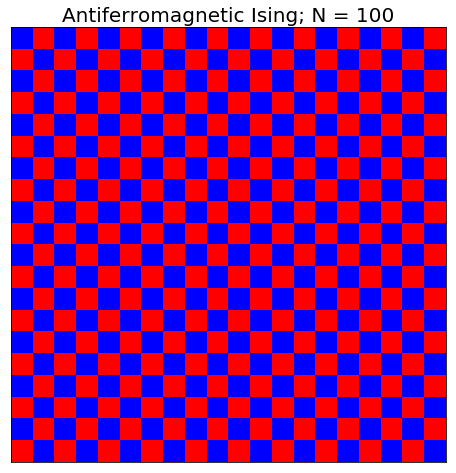

In [105]:
s = mult_sweeps_af(init, test_boltz, 100, plot = True, title = 'Antiferromagnetic Ising; N = 100')

In [106]:
stag_mag(s)

-400.0

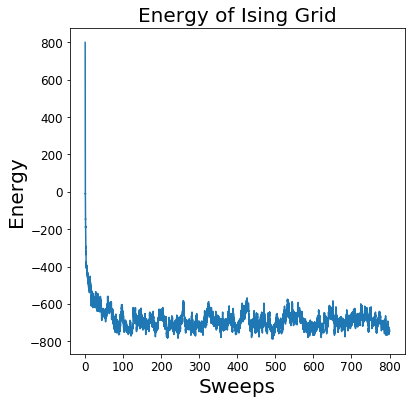

In [146]:
init = copy.copy(ones)

elist = energy_evo_af(init, test_boltz, 400*800, plot = True)

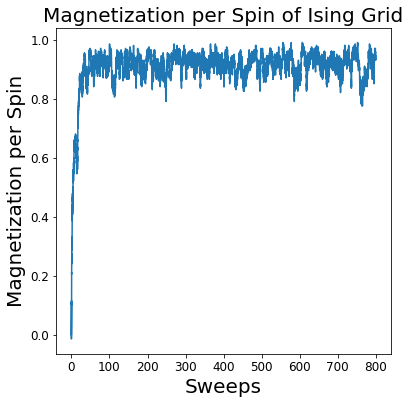

In [147]:
smlist = stag_mag_evo(init, test_boltz, 400*800, plot = True)

In [123]:
temps = [i for i in np.arange(1, 3.5, 0.01)]
init20 = copy.copy(ones)

In [125]:
n_eq = 250
n = 150
n1 = 1/(n * 20**2)
n2 = 1/(n**2 * 20**2)

eneps_list20 = np.zeros(len(temps))
spec_heat20 = np.zeros(len(temps))
smagps_list20 = np.zeros(len(temps))
smag_sus20 = np.zeros(len(temps))

In [126]:
grid = copy.copy(init20)

start = time.time()

for i in range(len(temps)):
    T = temps[i]
    boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}
    
    grid = mult_sweeps_af(grid, boltz, n_eq)
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    sm_total = 0
    sm2_total = 0
    
    # measurements to average
    for k in range(n):
        grid = mc_sweep_af(grid, boltz)
        energy = ising_energy_af(grid)
        smag = stag_mag(grid)
        
        e_total += energy
        e2_total += energy*energy
        sm_total += smag
        sm2_total += smag*smag
        
        
    # compute averages
    eneps_list20[i] = n1*e_total
    spec_heat20[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    smagps_list20[i] = n1*sm_total
    smag_sus20[i] = (n1*sm2_total - n2*sm_total*sm_total)/(T*T)
    
    
    if (T % 1) < 0.001:
        tick = time.time()
        print(f'T = {T}; {tick - start} seconds')
            

 

T = 1.0; 0.8570873737335205 seconds
T = 2.000000000000001; 87.08318376541138 seconds
T = 3.0000000000000018; 176.51195120811462 seconds


Text(0,0.5,'Stag. Susceptibility')

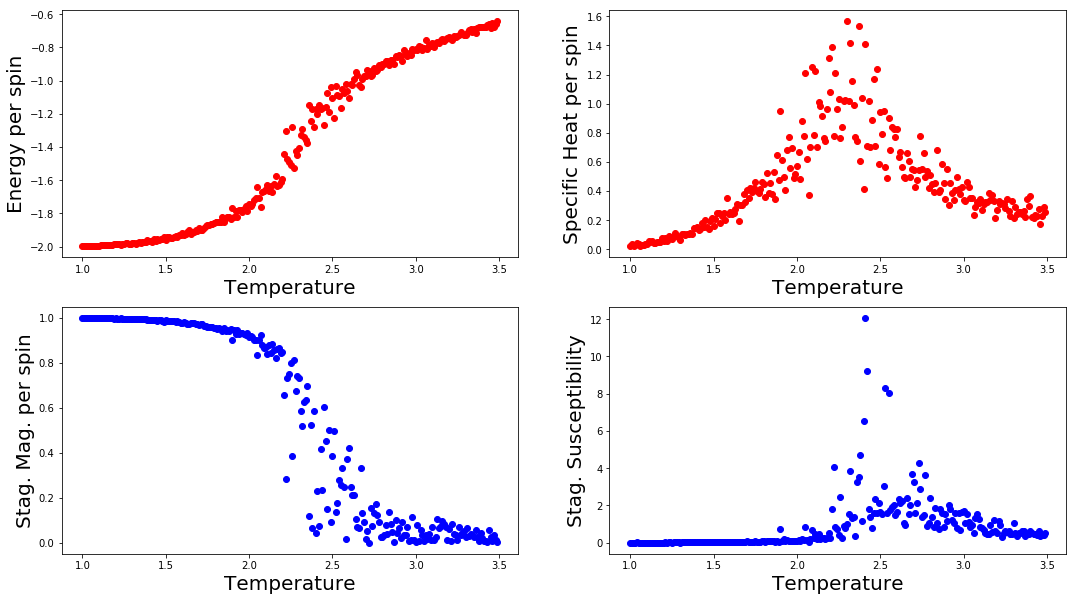

In [127]:
fig = plt.figure(figsize=(18, 10)) # plot the calculated values    

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list20, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat20, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, abs(smagps_list20), 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Stag. Mag. per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, smag_sus20, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Stag. Susceptibility", fontsize=20)

In [128]:
np.save('AFeneps20.npy',eneps_list20)
np.save('AFspec_heat20.npy',spec_heat20)
np.save('AFsmagps20.npy',smagps_list20)
np.save('AFsmag_sus20.npy',smag_sus20)

In [148]:
temps = [i for i in np.arange(1, 3.5, 0.01)]
ones30 = np.ones((30,30))
init30 = copy.copy(ones30)

In [149]:
n_eq = 300
n = 150
n1 = 1/(n * 30**2)
n2 = 1/(n**2 * 30**2)

eneps_list30 = np.zeros(len(temps))
spec_heat30 = np.zeros(len(temps))
smagps_list30 = np.zeros(len(temps))
smag_sus30 = np.zeros(len(temps))

In [ ]:
grid = copy.copy(init30)

start = time.time()

for i in range(len(temps)):
    T = temps[i]
    boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}
    
    grid = mult_sweeps_af(grid, boltz, n_eq)
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    sm_total = 0
    sm2_total = 0
    
    # measurements to average
    for k in range(n):
        grid = mc_sweep_af(grid, boltz)
        energy = ising_energy_af(grid)
        smag = stag_mag(grid)
        
        e_total += energy
        e2_total += energy*energy
        sm_total += smag
        sm2_total += smag*smag
        
        
    # compute averages
    eneps_list30[i] = n1*e_total
    spec_heat30[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    smagps_list30[i] = n1*sm_total
    smag_sus30[i] = (n1*sm2_total - n2*sm_total*sm_total)/(T*T)
    
    
    if (T % 1) < 0.001:
        tick = time.time()
        print(f'T = {T}; {tick - start} seconds')
            

 

T = 1.0; 2.246877908706665 seconds
T = 2.000000000000001; 221.44259023666382 seconds
T = 3.0000000000000018; 441.6337733268738 seconds


Text(0,0.5,'Stag. Susceptibility')

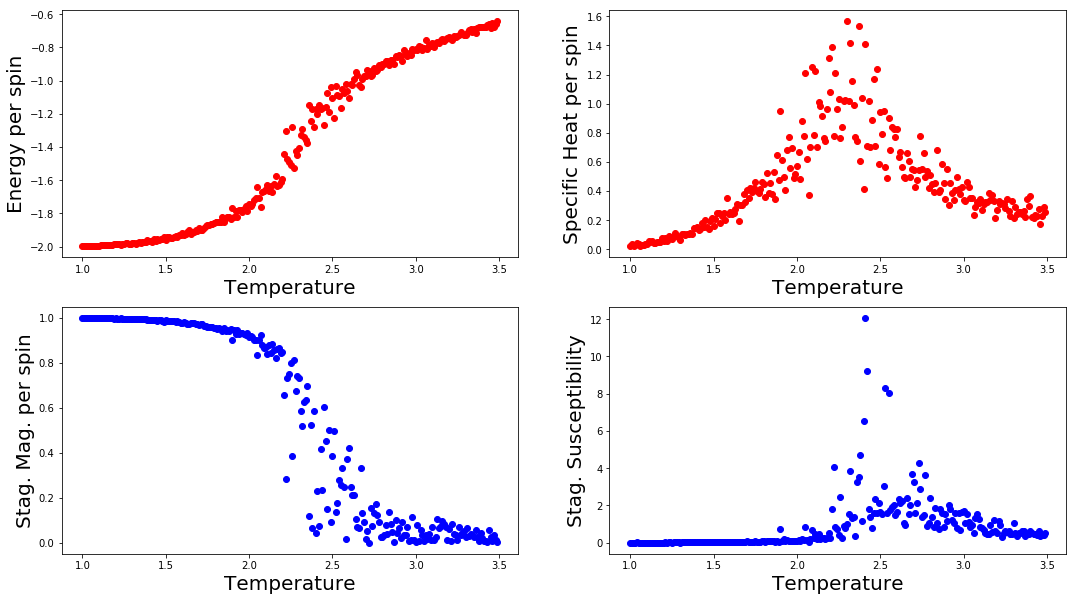

In [127]:
fig = plt.figure(figsize=(18, 10)) # plot the calculated values    

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list20, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat20, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, abs(smagps_list20), 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Stag. Mag. per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, smag_sus20, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Stag. Susceptibility", fontsize=20)